## Small-scale synthetic experiments with binary sparse vector

### Example: estimation error as a function of the sample size

This notebook presents a small-scale example that demonstrates the advantage of an exhaustive method for solving our QUBO formualtion to the sparse coding problem. For demonstration purpuses the code below runs on a classic computer. It is important to emphasize that our QUBO problem can be minimized on quantum computers or other quantum-inspired solvers, see our paper for larger-scale experiments.

We start by generating a matrix $A$ with $L_2$-normalized columns such that its mutual coherence is minimized.
Then, given $A$, we generate a vector $\bar{b}=Ax$ by drawing an $x$ with $k$ randomly chosen non-zero **binary** entries that are equal to one, and then form its noisy version $b = \bar{b} + v$, where the noise component $v$ is sampled from a normal distribution with zero mean  standard deviation (STD) $\sigma$. Now, given $A$ and the noisy $b$, we attempt to reconstruct $x$ via (1) lasso, (2) OMP, (3) an exhaustive algorithm for solving the original sparse coding problem, and (4) an exhaustive QUBO solver for the original sparse coding problem. 

Due to the high computational complexity of the exhaustive solvers, we run this experiment only for a matrix $A$ with a small the number of columns, which we set to $N=16$. The hyper-parameter of each method is tuned by an oracle that has access to the true $x$, optimizing each of the two error metrics presented in the graphs.


In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import sys

base_code_path = "./"

sys.path.append(base_code_path)
sys.path.append(base_code_path + "/solvers")
sys.path.append(base_code_path + "/utils")
sys.path.append(base_code_path + "/solvers_experiments")

pd.set_option('display.max_columns', None)

from utils import utils

#########################
# Experiment parameters #
#########################

#Type of A
type_A = "low_coherence"

# Number of (features) variables
N = 16
# how much Gaussian noise N(0, 1) to add to the measurement vector
b_noise_coef = 0.1
# Number of non-zero variables (cardinality)
K = 3

# Number of measurements
M_vec = [6, 8, 10, 12, 14, 16]


# Set the threshold to the absolute value of and element of a solution
# vector, under which this element is considered as zero for cardinality
L0_th = 1e-1

# number of trials per experiemnt
num_exps = 20

# binary x0 (0) or P-bits (1)?
type_x0_id = 0
TYPE_X_LIST =  ["binary",
                "fixed_point"]
type_x0 = TYPE_X_LIST[type_x0_id]

print("Type A:\n  " + type_A)
print("Type x0:\n  " + type_x0)
sys.stdout.flush()

# internal normalization of A (lasso)
lasso_normalize = True

# Set the parameters for uniform discrete
# The values of the solution must include 0 and their number must be
# a positive power of 2
if type_x0 == "fixed_point":
    x0_min = 0
    d_x0 = 1
    P = 2
    num_bits = P

    w_fp = 10

    x_ip_0_spins = utils.check_fixed_point_parameters(x0_min, d_x0, P)

    # Set the parameters to generate a valid solution to the linear system
    params_x0 = (x0_min, d_x0, P)

    # %% Display info
    print("N =", N, ",  K =", K, ",  M = ", M)
    x_vals = x0_min + d_x0 * np.arange(2 ** P)
    print("x_vals =")
    print(" ", x_vals)
    x0_max = max(x_vals)

elif type_x0 == "binary":
    x0_min = 0
    x0_max = 1
    num_bits = 1
    d_x0 = 1
    w_fp = 50
else:
    1/0

params_x0 = (x0_min, x0_max + 1e-10, d_x0)

print("N =", N, ",  K =", K)
print("x0_min =", x0_min, ",  x0_max =", x0_max, ',  dx0 =', d_x0)


# arrrange params for the solver
params = dict()
params["x0_min"]   = x0_min
params["x0_max"]   = x0_max
params["num_bits"] = num_bits
params["d_x0"]     = d_x0
params["w_fp"]     = w_fp

Type A:
  low_coherence
Type x0:
  binary
N = 16 ,  K = 3
x0_min = 0 ,  x0_max = 1 ,  dx0 = 1


In [2]:

import warnings
warnings.filterwarnings(action='ignore')

###################
# Core execution #
###################

from solvers_experiments import random_linear_system as RLS
from solvers import annealer
from solvers import others

def get_stats(s_L, r_L, r_L_test):
    # Find the best solution, minimizing the L2 distance between x_hat and x_0
    tmp = s_L[:,2]
    ind_best_solution_x = np.argmin(tmp)
    rec_err_x = tmp[ind_best_solution_x]
    rmse = r_L[ind_best_solution_x]

    # Find the best solution, minimizing the L0 distance between x_hat and x_0
    tmp = s_L[:,0]
    ind_best_solution_x = np.argmin(tmp)
    cardinality_err_x = s_L[ind_best_solution_x,0]


    # Find the best CV solution, minimizing the test system error
    ind_best_solution_cv_sys = np.argmin(r_L_test)
    cv_rec_err_x = s_L[ind_best_solution_cv_sys,2]
    cv_cardinality_err_x = s_L[ind_best_solution_cv_sys,0]
    cv_rmse = r_L_test[ind_best_solution_cv_sys]

    return rec_err_x, cardinality_err_x, rmse, cv_rec_err_x, cv_cardinality_err_x, cv_rmse


# Initialize table of results
results = pd.DataFrame()


methods_to_run = ["exhaustive_L0", "exhaustive_qubo_L0", "lasso_L1", "omp_L0"]

for M_id, M in enumerate(M_vec):
    for exp_id in range(num_exps):
        print("M_id: " + str(M_id+1) + "/" + str(len(M_vec)) + " exp_id: " + str(exp_id+1) + "/" + str(num_exps))
        sys.stdout.flush()

        # %% Form the system of equations
        [A, b, x0] = \
            RLS.generate_random_linear_system(N=N, M=M, K=K,
                                              type_A=type_A,
                                              type_x0=type_x0, params_x0=params_x0,
                                              b_noise_coef=b_noise_coef, seed=exp_id)

        A_test=A
        b_test=b


        # %% Apply L0 regularization (classical)
        if "exhaustive_L0" in methods_to_run:
            x_L0, r_L0, r_L0_test, k_L0, s_L0 = others.exhaustive_L0(A, b,
                                                                     A_test, b_test,
                                                                     L0_th=L0_th, x0=x0)


            rec_err_L0, cardinality_err_L0, rmse_L0, \
                cv_rec_err_L0, cv_cardinality_err_L0, cv_rmse_L0 = \
                    get_stats(s_L0, r_L0, r_L0_test)

            # Store results
            results = results.append({'Experiment':exp_id,
                                      'Cardinality': K,
                                      'Noise STD': b_noise_coef,
                                      'Method':'Exhaustive L0',
                                      'Infeasible X-Recovery L2 Err':rec_err_L0,
                                      'Infeasible X-Recovery L0 Err':cardinality_err_L0,
                                      'Infeasible System RMSE':rmse_L0,
                                      'CV X-Recovery L2 Err':cv_rec_err_L0,
                                      'CV X-Recovery L0 Err':cv_cardinality_err_L0,
                                      'CV System RMSE':cv_rmse_L0,
                                      'Type A':type_A,
                                      'Normalize A':lasso_normalize,
                                      'L0 Thresh':L0_th,
                                      'N':N,
                                      'M':M,
                                      'x0_min':x0_min,
                                      'x0_max':x0_max,
                                      'num_bits':num_bits,
                                      'd_x0':d_x0,
                                      'w_fp':w_fp,
                                      'type_x0':type_x0},
                                      ignore_index=True)



        # %% Apply L0 regularization (QUBO)
        if "exhaustive_qubo_L0" in methods_to_run:
            lambda_max = sum(np.abs(A.T@b))
            eps = 1e-8
            n_grid = 20
            lam_L0 = np.logspace(np.log10(lambda_max * eps), np.log10(lambda_max), num=n_grid)[::-1]
            np.append(lam_L0, 1e-10)
            np.append(lam_L0, 1e-15)


            x_qubo, r_qubo, r_qubo_test, k_qubo, s_qubo = \
                annealer.exhaustive_qubo_Lp(A, b,
                                            A_test, b_test,
                                            norm="L0",
                                            params=params,
                                            lam_Lp=lam_L0,
                                            L0_th=L0_th, x0=x0)



            rec_err_qubo, cardinality_err_qubo, rmse_qubo, \
                cv_rec_err_qubo, cv_cardinality_err_qubo, cv_rmse_qubo = \
                    get_stats(s_qubo, r_qubo, r_qubo_test)

            # Store results
            results = results.append({'Experiment':exp_id,
                                      'Cardinality': K,
                                      'Noise STD': b_noise_coef,
                                      'Method':'QUBO L0',
                                      'Infeasible X-Recovery L2 Err':rec_err_qubo,
                                      'Infeasible X-Recovery L0 Err':cardinality_err_qubo,
                                      'Infeasible System RMSE':rmse_qubo,
                                      'CV X-Recovery L2 Err':cv_rec_err_qubo,
                                      'CV X-Recovery L0 Err':cv_cardinality_err_qubo,
                                      'CV System RMSE':cv_rmse_qubo,
                                      'Type A':type_A,
                                      'Normalize A':lasso_normalize,
                                      'L0 Thresh':L0_th,
                                      'N':N,
                                      'M':M,
                                      'x0_min':x0_min,
                                      'x0_max':x0_max,
                                      'num_bits':num_bits,
                                      'd_x0':d_x0,
                                      'w_fp':w_fp,
                                      'type_x0':type_x0},
                                      ignore_index=True)


        # Apply L1 regularization
        if "lasso_L1" in methods_to_run:
            x_L1, r_L1, r_L1_test, k_L1, s_L1 = others.lasso_L1(A, b,
                                                                A_test, b_test,
                                                                lasso_normalize,
                                                                L0_th=L0_th, x0=x0)

            rec_err_L1, cardinality_err_L1, rmse_L1, \
                cv_rec_err_L1, cv_cardinality_err_L1, cv_rmse_L1 = \
                    get_stats(s_L1, r_L1, r_L1_test)

            # Store results
            results = results.append({'Experiment':exp_id,
                                      'Cardinality': K,
                                      'Noise STD': b_noise_coef,
                                      'Method':'Lasso',
                                      'Infeasible X-Recovery L2 Err':rec_err_L1,
                                      'Infeasible X-Recovery L0 Err':cardinality_err_L1,
                                      'Infeasible System RMSE':rmse_L1,
                                      'CV X-Recovery L2 Err':cv_rec_err_L1,
                                      'CV X-Recovery L0 Err':cv_cardinality_err_L1,
                                      'CV System RMSE':cv_rmse_L1,
                                      'Type A':type_A,
                                      'Normalize A':lasso_normalize,
                                      'L0 Thresh':L0_th,
                                      'N':N,
                                      'M':M,
                                      'x0_min':x0_min,
                                      'x0_max':x0_max,
                                      'num_bits':num_bits,
                                      'd_x0':d_x0,
                                      'w_fp':w_fp,
                                      'type_x0':type_x0},
                                      ignore_index=True)




        # %%
        # Apply L0 regularization using OMP
        if "omp_L0" in methods_to_run:
            x_omp, r_omp, r_omp_test, k_omp, s_omp = others.omp_L0(A, b,
                                                                   A_test, b_test,
                                                                   L0_th=L0_th, x0=x0)

            rec_err_omp, cardinality_err_omp, rmse_omp, \
                cv_rec_err_omp, cv_cardinality_err_omp, cv_rmse_omp = \
                    get_stats(s_omp, r_omp, r_omp_test)

            # Store results
            results = results.append({'Experiment':exp_id,
                                      'Cardinality': K,
                                      'Noise STD': b_noise_coef,
                                      'Method':'OMP',
                                      'Infeasible X-Recovery L2 Err':rec_err_omp,
                                      'Infeasible X-Recovery L0 Err':cardinality_err_omp,
                                      'Infeasible System RMSE':rmse_omp,
                                      'CV X-Recovery L2 Err':cv_rec_err_omp,
                                      'CV X-Recovery L0 Err':cv_cardinality_err_omp,
                                      'CV System RMSE':cv_rmse_omp,
                                      'Type A':type_A,
                                      'Normalize A':lasso_normalize,
                                      'L0 Thresh':L0_th,
                                      'N':N,
                                      'M':M,
                                      'x0_min':x0_min,
                                      'x0_max':x0_max,
                                      'num_bits':num_bits,
                                      'd_x0':d_x0,
                                      'w_fp':w_fp,
                                      'type_x0':type_x0},
                                      ignore_index=True)


M_id: 1/6 exp_id: 1/20
Init loss = 0.1403864622116089 , final loss = 0.1041666641831398
M_id: 1/6 exp_id: 2/20
Init loss = 0.15844231843948364 , final loss = 0.1041666716337204
M_id: 1/6 exp_id: 3/20
Init loss = 0.17129090428352356 , final loss = 0.1041666567325592
M_id: 1/6 exp_id: 4/20
Init loss = 0.21720342338085175 , final loss = 0.1041666716337204
M_id: 1/6 exp_id: 5/20
Init loss = 0.14490625262260437 , final loss = 0.1041666641831398
M_id: 1/6 exp_id: 6/20
Init loss = 0.15727071464061737 , final loss = 0.1041666567325592
M_id: 1/6 exp_id: 7/20
Init loss = 0.161238431930542 , final loss = 0.1041666641831398
M_id: 1/6 exp_id: 8/20
Init loss = 0.14241907000541687 , final loss = 0.1041666567325592
M_id: 1/6 exp_id: 9/20
Init loss = 0.14131709933280945 , final loss = 0.1041666567325592
M_id: 1/6 exp_id: 10/20
Init loss = 0.16351845860481262 , final loss = 0.1041666641831398
M_id: 1/6 exp_id: 11/20
Init loss = 0.1643829643726349 , final loss = 0.1041666641831398
M_id: 1/6 exp_id: 12/20

Init loss = 0.07524219155311584 , final loss = 0.008929009549319744
M_id: 5/6 exp_id: 14/20
Init loss = 0.07472753524780273 , final loss = 0.008950537070631981
M_id: 5/6 exp_id: 15/20
Init loss = 0.058172546327114105 , final loss = 0.008929833769798279
M_id: 5/6 exp_id: 16/20
Init loss = 0.07279755175113678 , final loss = 0.008949898183345795
M_id: 5/6 exp_id: 17/20
Init loss = 0.06813028454780579 , final loss = 0.008929002098739147
M_id: 5/6 exp_id: 18/20
Init loss = 0.06835509836673737 , final loss = 0.008930511772632599
M_id: 5/6 exp_id: 19/20
Init loss = 0.056644849479198456 , final loss = 0.008929789066314697
M_id: 5/6 exp_id: 20/20
Init loss = 0.06708978116512299 , final loss = 0.008928864262998104
M_id: 6/6 exp_id: 1/20
Init loss = 0.05645233392715454 , final loss = 7.735918703581993e-14
M_id: 6/6 exp_id: 2/20
Init loss = 0.07281238585710526 , final loss = 8.445574426439728e-14
M_id: 6/6 exp_id: 3/20
Init loss = 0.05980804190039635 , final loss = 7.52309523813395e-14
M_id: 6/6 e

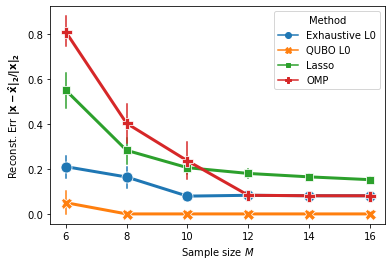

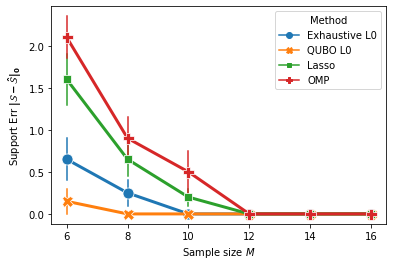

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# plot recovery error as a function of noise std
df = results
df = df[df["Cardinality"]==K]
df = df[df["M"]<=N]
df = df[df["Noise STD"]==0.1]
df = df[df["Method"].isin(['QUBO L0', 'Exhaustive L0', 'Lasso', 'OMP'])]


sns.lineplot(x = "M", y = "Infeasible X-Recovery L2 Err", ci=68, err_style='bars', style="Method",markers=True, dashes=False,markersize=11,linewidth=3,
             data = df[["Experiment", "Method","M","Infeasible X-Recovery L2 Err"]],hue='Method')
plt.ylabel(r'Reconst. Err $\mathbf{\|x-\hat{x}\|_2/\|x\|_2}$')
plt.xlabel(r'Sample size $M$')
# plt.legend()
plt.show()

# plot recovery error as a function of noise std
df = results
df = df[df["Cardinality"]==K]
df = df[df["M"]<=N]
df = df[df["Noise STD"]==0.1]
df = df[df["Method"].isin(['QUBO L0', 'Exhaustive L0', 'Lasso', 'OMP'])]


sns.lineplot(x = "M", y = "Infeasible X-Recovery L0 Err", ci=68, err_style='bars', style="Method",markers=True, dashes=False,markersize=11,linewidth=3,
             data = df[["Experiment", "Method","M","Infeasible X-Recovery L0 Err"]],hue='Method')
plt.ylabel(r'Support Err $\mathbf{\|\mathcal{S} - \hat{\mathcal{S}} \|_0}$')
plt.xlabel(r'Sample size $M$')
# plt.legend()
plt.show()
